## 10. Early Stopping

- 학습 도중 **Validation Loss가 더 이상 줄어들지 않으면 학습을 멈추는 방법**
- 과적합을 방지하고 불필요한 학습 시간을 줄임
- 단순히 한 번 증가했다고 멈추면 **노이즈에 민감할 수 있으므로**,
    
    `patience`를 설정하여 **연속으로 loss가 증가할 때**만 멈춤
    
    ⇒ 예: `patience = 3`이면, 3번 연속으로 loss가 나빠질 때 종료

In [18]:
import pandas as pd

df = pd.read_csv('data/swirl_10k.csv')

data = df[['x', 'y']].values
labels = df['label'].values.reshape(-1, 1)

print(f'data: {data}, labels: {labels}')


data: [[-0.30249982  0.35228178]
 [-0.89796171  0.10499859]
 [-0.53929324 -0.17153895]
 ...
 [ 0.52112207 -0.09355757]
 [-0.10692036 -0.50632611]
 [ 0.33397909  0.69549823]], labels: [[1.]
 [0.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


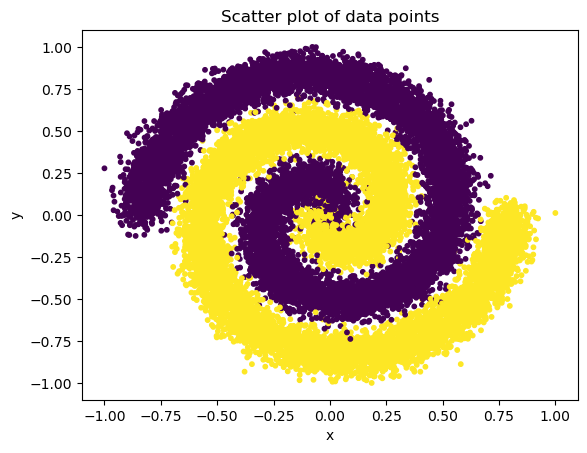

In [19]:
import matplotlib.pyplot as plt

plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=10)
plt.title('Scatter plot of data points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [20]:
import torch
import torch.nn.functional as F

data_torch = torch.tensor(data, dtype=torch.float32)
labels_torch = torch.tensor(labels, dtype=torch.float32)

# 학습데이터를 7:3 정도로 train/validation으로 나누기
data_length = len(data_torch)
split_n = int(data_length * 0.7)
train_data = data_torch[:split_n]
train_labels = labels_torch[:split_n]
val_data = data_torch[split_n:]
val_labels = labels_torch[split_n:]


In [21]:
g = torch.Generator().manual_seed(42)

# 배치로 데이터를 묶음(mini-batch)
def get_batch(x, y, batch_size):
  data_length = len(x)
  indices = torch.randint(0, data_length, (batch_size,), generator=g)

  x_batch = x[indices]
  y_batch = y[indices]
  return x_batch, y_batch

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim 

g.manual_seed(42)
torch.manual_seed(42)

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    self.seq_model = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(hidden_size, output_size)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.seq_model(x)
  

net = Net(2, 16, 1)
train_losses = []
val_losses = []

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for steps in range(50000):
  net.train()
  data_batch, label_batch = get_batch(train_data, train_labels, 256)
  output = net(data_batch)
  
  loss = loss_fn(output, label_batch)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  

  if steps % 10 == 0:
    net.eval()
    output = net(val_data)
    val_loss = loss_fn(output, val_labels)
    val_losses.append(val_loss.item())

    output = net(train_data)
    train_loss = loss_fn(output, train_labels)
    train_losses.append(train_loss.item())
    if steps % 1000 == 0:
      print(f"{steps} val_loss: {val_loss.item()}, train_loss: {train_loss.item()}")


0 val_loss: 0.6951403617858887, train_loss: 0.6962078213691711
1000 val_loss: 0.6916131377220154, train_loss: 0.6913983821868896
2000 val_loss: 0.6891796588897705, train_loss: 0.6888722777366638
3000 val_loss: 0.6829337477684021, train_loss: 0.682271420955658
4000 val_loss: 0.6671044230461121, train_loss: 0.6656609773635864
5000 val_loss: 0.6484845876693726, train_loss: 0.6459429264068604
6000 val_loss: 0.6374170780181885, train_loss: 0.6338410973548889
7000 val_loss: 0.6289548277854919, train_loss: 0.6249554753303528
8000 val_loss: 0.6199846267700195, train_loss: 0.6153055429458618
9000 val_loss: 0.6038526296615601, train_loss: 0.5984063148498535
10000 val_loss: 0.5774194598197937, train_loss: 0.5702510476112366
11000 val_loss: 0.5457779765129089, train_loss: 0.5366898775100708
12000 val_loss: 0.5233768820762634, train_loss: 0.5135912895202637
13000 val_loss: 0.5091387629508972, train_loss: 0.49873295426368713
14000 val_loss: 0.4987950026988983, train_loss: 0.4877716302871704
15000 va

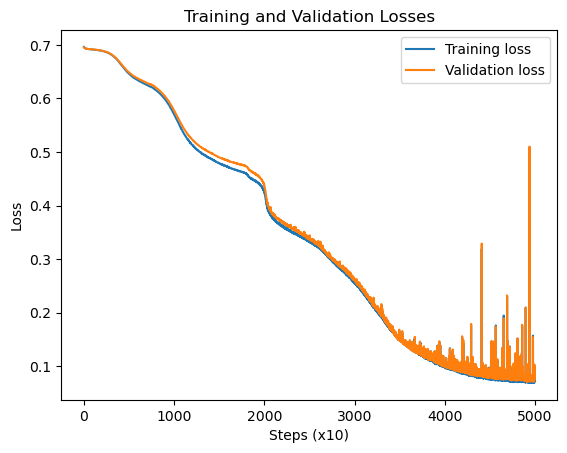

In [23]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')

plt.title('Training and Validation Losses')
plt.xlabel('Steps (x10)')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim 

g.manual_seed(42)
torch.manual_seed(42)

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    self.seq_model = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(hidden_size, output_size)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.seq_model(x)
  

net = Net(2, 16, 1)
train_losses = []
val_losses = []

# Early stopping 변수
min_val_loss = float('inf')
patience = 20
steps_no_improvement = 0
min_step = 0

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for steps in range(50000):
  net.train()
  data_batch, label_batch = get_batch(train_data, train_labels, 256)
  output = net(data_batch)
  
  loss = loss_fn(output, label_batch)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  

  if steps % 10 == 0:
    net.eval()
    output = net(val_data)
    val_loss = loss_fn(output, val_labels)
    val_losses.append(val_loss.item())

    # Early stopping 적용(val_loss가 개선되지 않으면 patience만큼 기다린 후 학습 중지)
    if val_loss < min_val_loss:
      min_val_loss = val_loss
      steps_no_improvement = 0
      min_step = steps
    else:
      steps_no_improvement += 1
      if steps_no_improvement == patience:
        print(f"Early stopping at step {steps} with min_val_loss: {min_val_loss.item()}")
        break

    output = net(train_data)
    train_loss = loss_fn(output, train_labels)
    train_losses.append(train_loss.item())
    if steps % 1000 == 0:
      print(f"{steps} val_loss: {val_loss.item()}, train_loss: {train_loss.item()}")


0 val_loss: 0.6951403617858887, train_loss: 0.6962078213691711
1000 val_loss: 0.6916131377220154, train_loss: 0.6913983821868896
2000 val_loss: 0.6891796588897705, train_loss: 0.6888722777366638
3000 val_loss: 0.6829337477684021, train_loss: 0.682271420955658
4000 val_loss: 0.6671044230461121, train_loss: 0.6656609773635864
5000 val_loss: 0.6484845876693726, train_loss: 0.6459429264068604
6000 val_loss: 0.6374170780181885, train_loss: 0.6338410973548889
7000 val_loss: 0.6289548277854919, train_loss: 0.6249554753303528
8000 val_loss: 0.6199846267700195, train_loss: 0.6153055429458618
9000 val_loss: 0.6038526296615601, train_loss: 0.5984063148498535
10000 val_loss: 0.5774194598197937, train_loss: 0.5702510476112366
11000 val_loss: 0.5457779765129089, train_loss: 0.5366898775100708
12000 val_loss: 0.5233768820762634, train_loss: 0.5135912895202637
13000 val_loss: 0.5091387629508972, train_loss: 0.49873295426368713
14000 val_loss: 0.4987950026988983, train_loss: 0.4877716302871704
15000 va

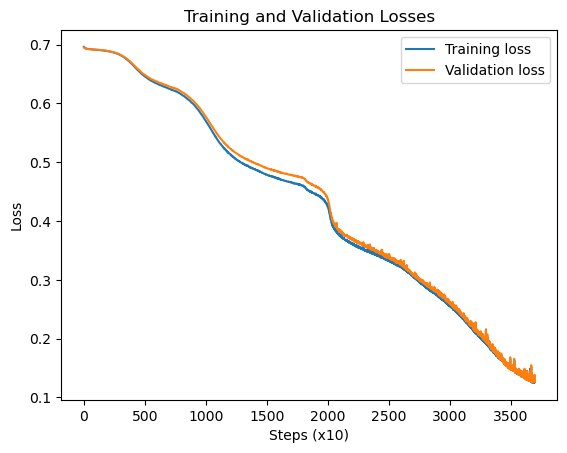

In [25]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')

plt.title('Training and Validation Losses')
plt.xlabel('Steps (x10)')
plt.ylabel('Loss')
plt.legend()

plt.show()